# TEA and LCA

* **Prepared by:**

    - Yalin Li

* **Covered topics:**

    - Techno-economic analysis (TEA)
        - ``TEA`` and ``SimpleTEA``
    - Life cycle assessment (LCA)
        - ``ImpactIndicator``
        - ``ImpactItem`` and ``StreamImpactItem``
        - ``Construction``, ``Transportation``, and other activities
        - ``LCA``

* **Update date:** 2021-01-19
* ``qsdsan`` **version:** 0.0.3

In [1]:
# To change directory to the cloned qsdsan (as opposed to the pip installed version)
# import os
# path = os.path.realpath('')+'/../../../'
# os.chdir(path)

In [2]:
import biosteam as bst
import qsdsan as qs
from qsdsan import sanunits as su
from qsdsan.systems import bwaise as bw

## Techno-economic analysis (TEA)
TEA in ``qsdsan`` is performed through the ``TEA`` object in ``biosteam``, but a new ``SimpleTEA`` class (subclass of ``TEA``) is added for simpler systems that are more relevant for sanitation-related studies.

For use of ``TEA``, follow the [tutorial](https://biosteam.readthedocs.io/en/latest/tutorial/Techno-economic_analysis.html) provided in ``biosteam`` documents.

### Features of ``SimpleTEA``
Here we will focus on some features of ``SimpleTEA``.

System: sys1
 path: (U1, U2)


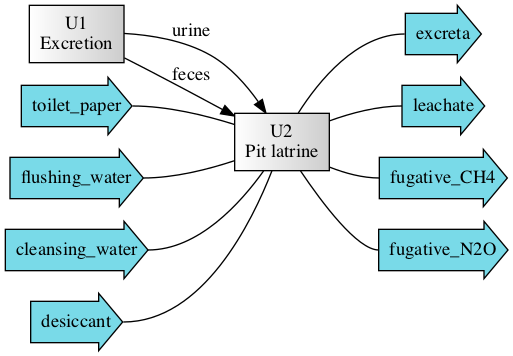

In [3]:
# First we need to construct a system, let's assume we want to look at a pit latrine
cmps = bw.cmps
bst.settings.set_thermo(cmps)
U1 = su.Excretion('U1', outs=('urine', 'feces'))
U2 = su.PitLatrine('U2', ins=(U1-0, U1-1, 'toilet_paper', 'flushing_water',
                              'cleansing_water', 'desiccant'),
                   outs=('excreta', 'leachate', 'fugative_CH4', 'fugative_N2O'),
                   N_user=4, N_toilet=2,
                  decay_k_COD=3, decay_k_N=3, max_CH4_emission=0.25)
sys1 = bst.System('sys1', path=(U1, U2))
sys1.simulate()
sys1.show()
sys1.diagram('thorough')

In [4]:
#  There is no costs associated with the Excretion unit
U1.results()

,Excretion,Units,U1
Total purchase cost,,USD,0
Utility cost,,USD/hr,0
Additional OPEX,,USD/hr,0


In [5]:
# But the PitLatrine unit has capital and operating costs
U2.results()

Pit latrine                                      Units       U2
Design              Number of users per toilet                4
                    Parallel toilets                          2
                    Emptying period                 yr      0.8
                    Single pit volume               m3     3.66
                    Single pit area                 m2      0.8
                    Single pit depth                       4.57
                    Cement                          kg  1.4e+03
                    Sand                            kg 6.34e+03
                    Gravel                          kg 2.56e+03
                    Brick                           kg      454
                    Plastic                         kg     20.2
                    Steel                           kg     67.2
                    Wood                            m3     0.38
                    Excavation                      m3     7.31
Purchase cost       Total toilets                  USD      898
Total purchase cost                                USD      898
Utility cost                                    USD/hr        0
Additional OPEX                                 USD/hr  0.00513

In [6]:
# Note that all SanUnit has a add_OPEX attribute where you can specify the OPEX cost per hr
# in addition to materials and utilities.
U2.add_OPEX

0.0051255707762557084

In [7]:
# With some assumptions, we can calculate costs associated with this system like
tea1 = qs.SimpleTEA(system=sys1, discount_rate=0.05, lifetime=10)
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 USD at 5.0% discount rate
EAC  : 184 USD/yr
CAPEX: 898 USD (annualized to 139 USD/yr)
AOC  : 45 USD/yr


In [8]:
# Or you directly access the net present value (NPV), equivalent annual cost (EAC),
# capital expenditure (CAPEX, or total capital cost), and annual operating cost (AOC)
tea1.EAC

183.8401886376576

In [9]:
# Currency depends on the setting of qsdsan
tea1.currency == qs.currency

True

In [10]:
# The following will return an error
# tea1.currency = 'euro'

In [11]:
qs.currency = 'euro'
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 euro at 5.0% discount rate
EAC  : 184 euro/yr
CAPEX: 898 euro (annualized to 139 euro/yr)
AOC  : 45 euro/yr


## Life cycle assessment (LCA)
### ``ImpactIndicator``
To do LCA, you first need to specify ``ImpactIndicator`` objects you want to use. ``qsdsan`` comes with the ones used in TRACI (Tool for Reduction and Assessment of Chemicals and Other Environmental Impacts), but you can define additional ones that you like.

In [12]:
# To access all impact indicators
qs.ImpactIndicator.get_all_indicators()

(<ImpactIndicator: NonCarcinogenics>,
 <ImpactIndicator: Carcinogenics>,
 <ImpactIndicator: GlobalWarming>,
 <ImpactIndicator: RespiratoryEffects>,
 <ImpactIndicator: Ecotoxicity>,
 <ImpactIndicator: OzoneDepletion>,
 <ImpactIndicator: PhotochemicalOxidation>,
 <ImpactIndicator: Eutrophication>,
 <ImpactIndicator: Acidification>)

In [13]:
# To access a specific indicator by its ID
PO = qs.ImpactIndicator.get_indicator('PhotochemicalOxidation')
# You can look at the properties for each indicator
PO.show()

ImpactIndicator: PhotochemicalOxidation as kg NOx-eq
 Method     : TRACI
 Category   : environmental impact
 Description: Potential to cause photoc...


In [14]:
# You can set synonyms for indicators
PO.set_synonym('PO')
PO.show()

ImpactIndicator: PhotochemicalOxidation as kg NOx-eq
 Synonyms   : PO
 Method     : TRACI
 Category   : environmental impact
 Description: Potential to cause photoc...


In [15]:
# Defining a new indicator is relative easy, at a minimum, you just need a unique ID
CEDf = qs.ImpactIndicator('CEDf')

In [16]:
CEDf.show()

ImpactIndicator: CEDf
 Method     : None
 Category   : None
 Description: None


In [17]:
# However, you probably also want to provide a unit to be used in calculations,
# and we want to add some decription to let other people know what it is
CEDf.unit = 'kJ'
CEDf.description = 'Cumulative energy demand-fossil'
CEDf.show()

ImpactIndicator: CEDf as kJ
 Method     : None
 Category   : None
 Description: Cumulative energy demand-...


### ``ImpactItem`` and ``StreamImpactItem``
Once you have impact indicators, you can start adding impact items and specify the relative impact each item with the quantity of one functional unit has for the different indicators.

#### ``ImpactItem``
For example, assume we need some electricity, and we know that to generate 1 kWh of electricity, 0.15 kg of CO2 is emitted, and it uses 4500 kJ of fossil energy.

In [18]:
electricity = qs.ImpactItem('electricity', functional_unit='kWh')

In [19]:
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0 USD
ImpactIndicators:
 None


In [20]:
# We can add characterization factors (CFs) for the two impact indicators
# GlobalWarming and CEDf
GWP = qs.ImpactIndicator.get_indicator('GWP')
electricity.add_indicator_CF(GWP, 0.25)
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25


In [21]:
# If you provide unit when adding the CF value, qsdsan will do the unit conversion
electricity.add_indicator_CF(CEDf, 3.6, 'MJ')
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25
CEDf (kJ)                                   3.6e+03


In [22]:
# If you later want to change this value, you can also do it
electricity.CFs['CEDf'] = 500
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25
CEDf (kJ)                                       500


In [23]:
# You can also provide the price for the item
electricity.price = 0.1
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0.1 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25
CEDf (kJ)                                       500


**Note:** The price is mainly used for construction and transportation items and will be included in unit CAPEX, if you want to add account for the cost of electricity, you should set the power utility usage of the unit and modify ``biosteam.PowerUtility.price``

#### ``StreamImpactItem``
A special case of impact items are ones related to material inputs and generated wastes/emissions, where it's more convenient to use ``StreamImpactItem`` (a subclass of ``ImpactItem``.

In [24]:
urine_item = qs.StreamImpactItem(linked_stream=U2-0, GWP=1)
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : excreta
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                         1


In [25]:
# For example, let's assume we want to account for the emissions with the waste stream of U2
# Note that indicator CFs can also be added via kwargs
urine_item = qs.StreamImpactItem(linked_stream=U2-0, GWP=1, CEDf=(1, 'MJ'))
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : excreta
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                         1
CEDf (kJ)                                     1e+03


In [26]:
# The price of this urine_item will be linked to the price of the stream
urine = U2.outs[0]
urine.price = 0.2
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : excreta
Price           : 0.2 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                         1
CEDf (kJ)                                     1e+03


In [27]:
# In designing the system, you may need multiple items of the same settings,
# for example you can have many urine streams, then you can link them to a same source
urine2 = qs.WasteStream('urine2', Water=100)
urine_item2 = urine_item.copy(stream=urine2, set_as_source=True)
urine_item2.show()

StreamImpactItem: [per kg]
Linked to       : urine2
Source          : excreta_item
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                         1
CEDf (kJ)                                     1e+03


In [28]:
# This works for ImpactItem objects other than StreamImpactItem as well
Cement2 = U2.construction[0].item.copy(new_ID='Copied cement', set_as_source=True)
Cement2.show()

ImpactItem      : Copied cement [per kg]
Source          : Cement
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      1.08


### ``Construction``, ``Transportation``, and other activities
With these defined impact items, we can now account for impacts with construction, transportation, and other activities during LCA.

#### ``Construction``
The ``Construction`` class is used to include impacts associated with the construction of a certain unit and is stored in the ``SanUnit.construction``.

In [29]:
# For example, the pit latrine has several construction activities
U2.construction

(<Construction: Cement>,
 <Construction: Sand>,
 <Construction: Gravel>,
 <Construction: Brick>,
 <Construction: Plastic>,
 <Construction: Steel>,
 <Construction: Wood>,
 <Construction: Excavation>)

In [30]:
Cement = U2.construction[0]
Cement.show()

Construction : Cement
Quantity     : 1400 kg
Total cost   : 0 USD
Total impacts:
                           Impacts
GlobalWarming (kg CO2-eq) 1.51e+03


In [31]:
# Each Construction activity is linked with an ImpactItem
Cement.item.show()

ImpactItem      : Cement [per kg]
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      1.08


In [32]:
# The total impact and cost is calculated through the quantity of the activity
# and the price/CFs of the its impact item
Cement.quantity

1400.0

In [33]:
Cement.impacts['GlobalWarming'] == Cement.item.CFs['GlobalWarming']*Cement.quantity

True

#### ``Transportation``
Similar to ``Construction``, each ``Transportation`` object is linked to an ``ImpactItem``, but it calculates the total impacts by taking into the transportation load, distance, and interval.

In [34]:
# For example, suppose we want to take calculate impacts associated with cars
# First to make an ImpactItem for this
car_item = qs.ImpactItem('car_item', functional_unit='kg*km', GWP=10)
car_item.show()

ImpactItem      : car_item [per kg*km]
Price           : 0 USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                        10


In [35]:
# Then to add the Transportation activity
# I'm using a weird unit for fun
car_trans = qs.Transportation(item='car_item', load_type='mass', load=5000, load_unit='kg',
                             distance=5e6, distance_unit='cm', interval=20)
car_trans.show()

Transportation: car_item [per trip]
Load          : 5000 kg
Distance      : 50.0 km
Interval      : 20 hr
Total cost    : 0 USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq)  2.5e+06


**Note:** Here the imapcts are calculated for each trip, in LCA, ``qsdsan`` will calculate how many trips are made in the entire lifetime of the system using ``interval``.

In [36]:
# Transportation activities are stored in ``SanUnit.transportation``
bw.A3.transportation

(<Transportation: Trucking>,)

In [37]:
Trucking = bw.A3.transportation[0]
Trucking.show()

Transportation: Trucking [per trip]
Load          : 9.86E+07 kg
Distance      : 5 km
Interval      : 7008 hr
Total cost    : 0 USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq) 9.57e+04


#### Other activities
If there are additional activities that are not covered by materials, construction, and transportation (e.g., electricity), you can add it when making the ``LCA`` object.

### ``LCA``
Finally, we can make the actual ``LCA`` object. Like ``TEA`` objects, each ``LCA`` object is linked with a ``System`` object. For illustration purpose, let's just use a pre-defined system (Scenario A in [Trimmer et al.](https://doi.org/10.1021/acs.est.0c03296)).

System: sysA
 path: (A1, A2, A3, treatA, A9, A10, A11,
        A12, A13)


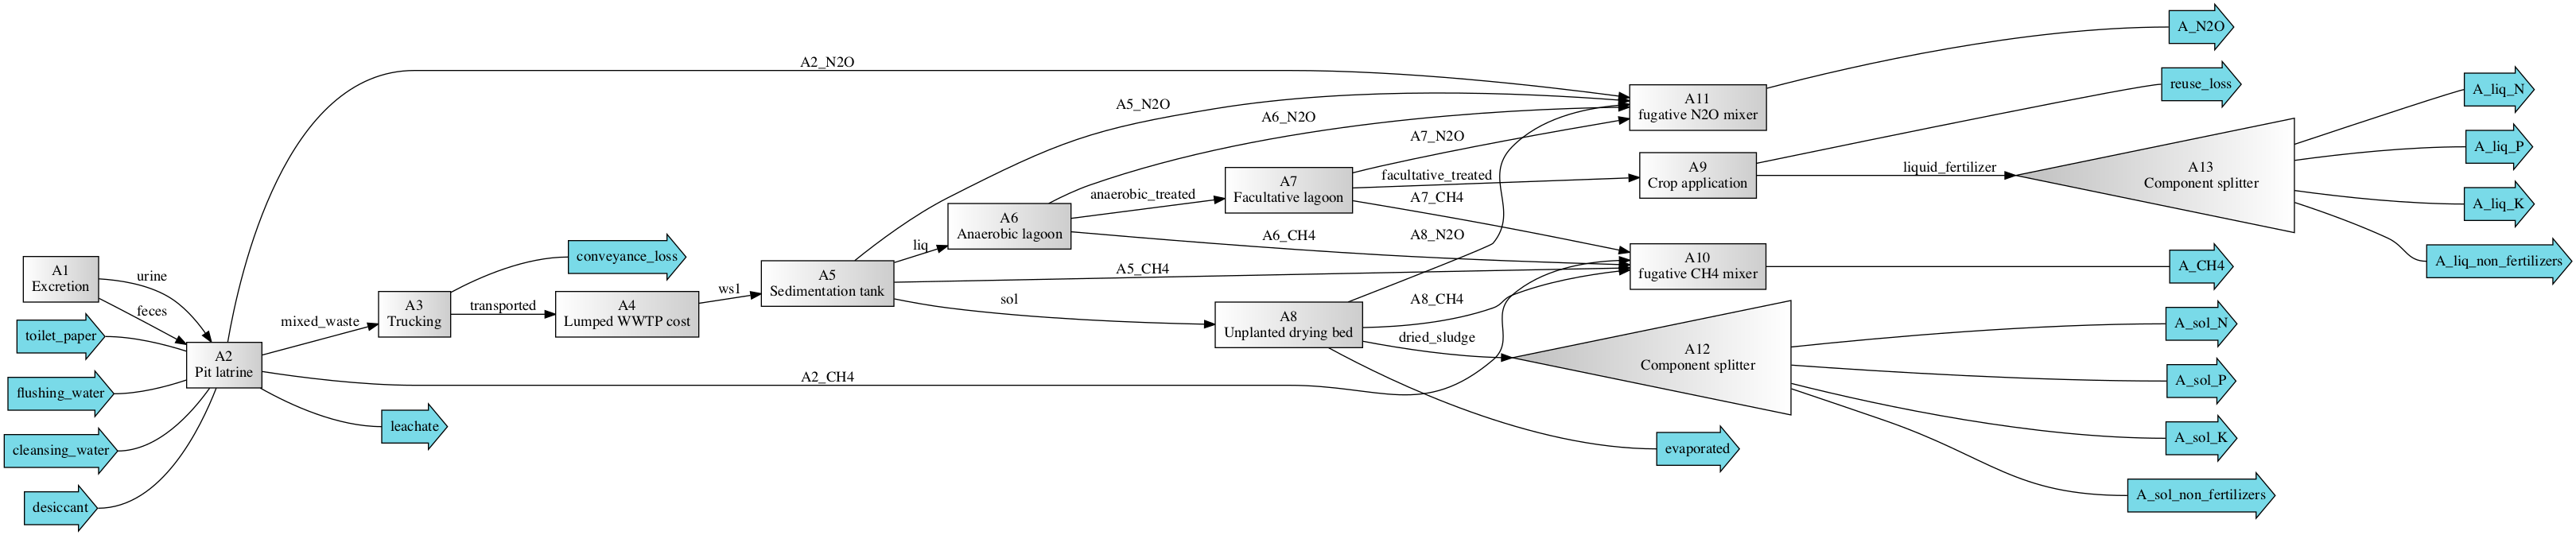

In [38]:
sys = bw.sysA
sys.show()
# You can double-click the diagram to enlarge it
sys.diagram('thorough')

In [39]:
# Note that here electricity is the additional impact activity that is not covered by
# construction, transportation, or material inputs/waste emissions
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr')

In [40]:
# Note that you can add impact activities not included in unit design and streams,
# in this case it's the electricity
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=1e6)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                           Construction  Transportation  WasteStream  Others    Total
CEDf (kJ)                             0               0            0   5e+08    5e+08
GlobalWarming (kg CO2-eq)      3.13e+07        9.57e+05     1.23e+08 2.5e+05 1.55e+08


In [41]:
# If impacts from those other activities change with simulation,
# you can add them as functions
import numpy as np
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=np.random.rand)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                           Construction  Transportation  WasteStream  Others    Total
CEDf (kJ)                             0               0            0    11.5      428
GlobalWarming (kg CO2-eq)      3.13e+07        9.57e+05     1.23e+08 0.00577 1.55e+08


In [42]:
# We can also get a more detailed break-down for a specific category
# Note that we need to redefine lca as the electricity 
lca.get_impact_table('Construction')

Quantity Item Ratio CEDf [kJ] Category CEDf Ratio  \
Construction    SanUnit                                                     
Brick [kg]      A2      6.47e+06          1         0                   0   
                Total   6.47e+06          1         0                   0   
Cement [kg]     A2         2e+07          1         0                   0   
                Total      2e+07          1         0                   0   
Concrete [m3]   A5           433     0.0667         0                   0   
                A8      6.06e+03      0.933         0                   0   
                Total   6.49e+03          1         0                   0   
Excavation [m3] A2      1.04e+05      0.731         0                   0   
                A5      1.45e+03     0.0102         0                   0   
                A6      1.39e+04     0.0975         0                   0   
                A7      2.31e+04      0.162         0                   0   
                Total   1.43e+05          1         0                   0   
Gravel [kg]     A2      3.65e+07          1         0                   0   
                Total   3.65e+07          1         0                   0   
Plastic [kg]    A2      2.88e+05      0.947         0                   0   
                A6      4.54e+03     0.0149         0                   0   
                A7      1.15e+04     0.0377         0                   0   
                Total   3.04e+05          1         0                   0   
Sand [kg]       A2      9.05e+07          1         0                   0   
                Total   9.05e+07          1         0                   0   
Steel [kg]      A2      9.58e+05      0.933         0                   0   
                A8      6.93e+04     0.0674         0                   0   
                Total   1.03e+06          1         0                   0   
Wood [m3]       A2      5.42e+03          1         0                   0   
                Total   5.42e+03          1         0                   0   
Sum             All                                 0                   1   

                        GlobalWarming [kg CO2-eq] Category GlobalWarming Ratio  
Construction    SanUnit                                                         
Brick [kg]      A2                       1.81e+06                       0.0578  
                Total                    1.81e+06                       0.0578  
Cement [kg]     A2                       2.16e+07                        0.689  
                Total                    2.16e+07                        0.689  
Concrete [m3]   A5                        1.3e+05                      0.00415  
                A8                       1.82e+06                        0.058  
                Total                    1.95e+06                       0.0621  
Excavation [m3] A2                       5.53e+04                      0.00176  
                A5                            769                     2.45e-05  
                A6                       7.38e+03                     0.000235  
                A7                       1.22e+04                      0.00039  
                Total                    7.57e+04                      0.00242  
Gravel [kg]     A2                       5.48e+05                       0.0175  
                Total                    5.48e+05                       0.0175  
Plastic [kg]    A2                       5.67e+05                       0.0181  
                A6                       8.94e+03                     0.000285  
                A7                       2.26e+04                     0.000721  
                Total                    5.98e+05                       0.0191  
Sand [kg]       A2                       1.09e+06                       0.0347  
                Total                    1.09e+06                       0.0347  
Steel [kg]      A2                       2.44e+06                        0.078  
    

In [43]:
lca.get_impact_table('Stream')

,Mass [kg],CEDf [kJ],Category CEDf Ratio,GlobalWarming [kg CO2-eq],Category GlobalWarming Ratio
Stream,,,,,
A_CH4,4.91e+06,0,0,1.38e+08,1.12
A_N2O,2.16e+04,0,0,5.72e+06,0.0466
A_liq_K,1.98e+06,0,0,-2.97e+06,-0.0242
A_liq_N,2.53e+06,0,0,-1.36e+07,-0.111
A_liq_P,3.46e+05,0,0,-1.69e+06,-0.0138
A_sol_K,3.02e+05,0,0,-4.53e+05,-0.00369
A_sol_N,1.28e+05,0,0,-6.91e+05,-0.00563
A_sol_P,2.14e+05,0,0,-1.05e+06,-0.00853
Sum,,0,1,1.23e+08,1


In [44]:
# For streams, you can specify kind to be 'all', 'direct_emission', or 'offset'
lca.get_stream_impacts(stream_items=lca.stream_inventory)

{'CEDf': 0.0, 'GlobalWarming': 122747785.49758293}

In [45]:
# You can also normalize the impacts to a certain stream
liq_N = bw.A13.outs[0]
lca.get_normalized_impacts(liq_N)

{'CEDf': 395.6224092375326, 'GlobalWarming': 168683238.263925}

In [46]:
# You can also look at all impacts associtated with a certain unit
lca.get_units_impacts(bw.A2)

{'CEDf': 64.00227872652353, 'GlobalWarming': 111628208.87013593}

In [47]:
# Finally, you can export all the details as an Excel file
lca.save_report('lca.xlsx')